In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
import re
from unidecode import unidecode
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

### 1. Initial data geathering

In [3]:
df=pd.read_csv('Assignment Data.csv',encoding='utf-8',usecols=['description','variety'])

In [4]:
df.sample(4)

,description,variety
31825,"This spicy wine is full of botrytis, giving a ...",Bordeaux-style White Blend
127089,"Nearly seven years after harvest, it remains l...",Tempranillo Blend
66406,"This has a lively presence in the mouth, with ...",Pinot Noir
84782,Waves of berry aromas matched by oak-based van...,Red Blend


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  129971 non-null  object
 1   variety      129970 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [6]:
df.isna().sum()

description    0
variety        1
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.duplicated().sum()

10006

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(119964, 2)

### 2. Crafting target columns

In [11]:
df['variety']=df['variety'].apply(lambda x : unidecode(x))

In [12]:
exclusion= string.punctuation

In [13]:
def remove_punch(text):
    for x in exclusion:
        text=text.replace(x,' ')
    return text

In [14]:
df['variety']=df['variety'].apply(remove_punch)

#### 2.1 Creating abstraction in target columns

In [15]:
#using insights about data

df['abstract_varieties']=df['variety'].apply(lambda x: x.replace('Bordeaux style ',''))
df['abstract_varieties']=df['abstract_varieties'].apply(lambda x: x.replace('Rhone style ',''))
df['abstract_varieties']=df['abstract_varieties'].apply(lambda x: x.replace('Provence ',''))
df['abstract_varieties']=df['abstract_varieties'].apply(lambda x: x.replace('Austrian ',''))
df['abstract_varieties']=df['abstract_varieties'].apply(lambda x: x.replace('Alvarelhao','Alvarinho'))
df['abstract_varieties']=df['abstract_varieties'].apply(lambda x: x.replace('Alvarinho Chardonnay','Alvarinho'))

In [16]:
df['abstract_varieties']=df['abstract_varieties'].apply(lambda x: x.lower())

In [18]:
#with regular expression

pattern=re.compile(r'\bcabernet|sauvignon')
def remove_sauvignon(text):
    l=pattern.findall(text)
    if len(l)>0:
        text='cabernet sauvignon'
    return text

In [19]:
df['abstract_varieties']=df['abstract_varieties'].apply(remove_sauvignon)

### 2.2 EDA

#### 2.2.1 Before applying heuristics

<AxesSubplot:ylabel='Density'>

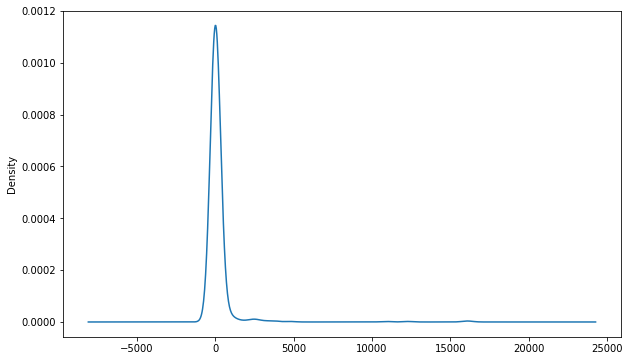

In [20]:
df['abstract_varieties'].value_counts().plot(kind='kde',figsize=(10,6))

<AxesSubplot:>

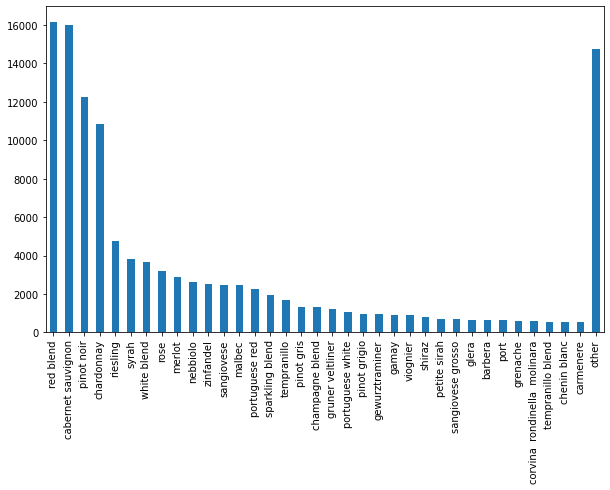

In [21]:
prob = df['abstract_varieties'].value_counts(normalize=False)
threshold = 500
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar',figsize=(10,6))

### 2.3 After applying some heuristics to reduce abnormality in distribution 

<AxesSubplot:>

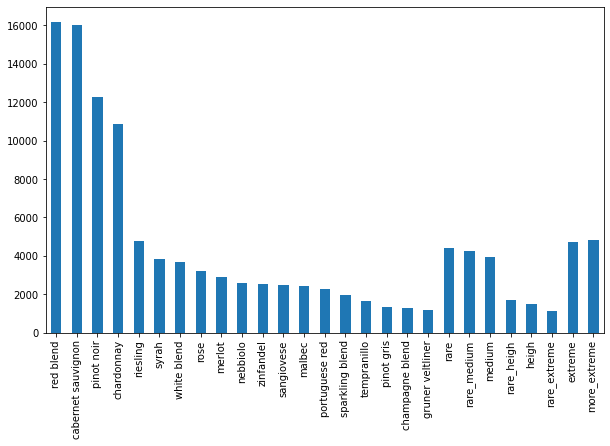

In [22]:
prob = df['abstract_varieties'].value_counts(normalize=False)

mask_rare = prob <= 50
mask_rare_medium = (prob <= 160) & (prob >50) 
mask_medium = (prob <=300) & (prob >160)
mask_rare_heigh = (prob <= 400) & (prob >300)
mask_heigh = (prob <= 550) & (prob >400)
mask_rare_extreme = (prob <= 600) & (prob >550)
mask_extreme=(prob <= 800) & (prob >600)
mask_more_extreme=(prob <= 1100) & (prob >800)


tail1_prob= prob.loc[mask_rare].sum()
tail2_prob=prob.loc[mask_rare_medium].sum()
tail3_prob=prob.loc[mask_medium].sum()
tail4_prob=prob.loc[mask_rare_heigh].sum()
tail5_prob=prob.loc[mask_heigh].sum()
tail6_prob=prob.loc[mask_rare_extreme].sum()
tail7_prob=prob.loc[mask_extreme].sum()
tail8_prob=prob.loc[mask_more_extreme].sum()



prob=prob.loc[~(mask_more_extreme+
                mask_rare_extreme+
                mask_extreme+
                mask_heigh+
                mask_rare_heigh+
                mask_medium+
                mask_rare_medium+
                mask_rare)]


prob['rare']=tail1_prob
prob['rare_medium']=tail2_prob
prob['medium']=tail3_prob
prob['rare_heigh']=tail4_prob
prob['heigh']=tail5_prob
prob['rare_extreme']=tail6_prob
prob['extreme']=tail7_prob
prob['more_extreme']=tail8_prob



prob.plot(kind='bar',figsize=(10,6))



<AxesSubplot:ylabel='Density'>

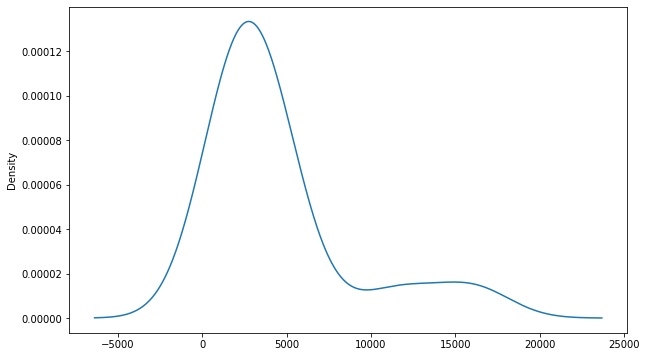

In [23]:
prob.plot(kind='kde',figsize=(10,6))

In [24]:
prob = df['abstract_varieties'].value_counts(normalize=False)
rare_dict = (prob <= 50).to_dict()
rare_medium_dict  = ((prob <= 160) & (prob >50)).to_dict()
medium_dict  = ((prob <=300) & (prob >160)).to_dict()
rare_heigh_dict  = ((prob <= 400) & (prob >300)).to_dict()
heigh_dict  = ((prob <= 550) & (prob >400)).to_dict()
rare_extreme_dict  = ((prob <= 600) & (prob >550)).to_dict()
extreme_dict = ((prob <= 800) & (prob >600)).to_dict()
more_extreme_dict = ((prob <= 1000) & (prob >800)).to_dict()

In [25]:
df['custom_varieties'] = df['abstract_varieties']

In [26]:
df['custom_varieties']=df['custom_varieties'].apply(lambda x: "rare" if x in rare_dict.keys() and rare_dict[x] == True else x)
df['custom_varieties']=df['custom_varieties'].apply(lambda x: "rare medium" if x in rare_medium_dict.keys() and rare_medium_dict[x] == True else x)
df['custom_varieties']=df['custom_varieties'].apply(lambda x: "medium" if x in rare_medium_dict.keys() and medium_dict[x] == True else x)
df['custom_varieties']=df['custom_varieties'].apply(lambda x: "rare heigh" if x in rare_heigh_dict.keys() and rare_heigh_dict[x] == True else x)
df['custom_varieties']=df['custom_varieties'].apply(lambda x: "high" if x in heigh_dict.keys() and heigh_dict[x] == True else x)
df['custom_varieties']=df['custom_varieties'].apply(lambda x: "rare extreme" if x in rare_extreme_dict.keys() and rare_extreme_dict[x] == True else x)
df['custom_varieties']=df['custom_varieties'].apply(lambda x: "extreme" if x in extreme_dict.keys() and extreme_dict[x] == True else x)
df['custom_varieties']=df['custom_varieties'].apply(lambda x: "more extreme" if x in more_extreme_dict.keys() and more_extreme_dict[x] == True else x)

In [27]:
df.sample(5)

,description,variety,abstract_varieties,custom_varieties
110368,"Blended with 16% Sauvignon Blanc, this wine br...",Semillon,semillon,rare medium
102183,"The gold luster is eye grabbing, and the nose ...",Chardonnay,chardonnay,chardonnay
118965,This gorgeous wine boasts alluring scents of f...,Red Blend,red blend,red blend
25956,"Very impressive color, fruit concentration and...",Petite Sirah,petite sirah,extreme
25474,"Made from Zinfandel, Carignane, Petite Sirah a...",Red Blend,red blend,red blend


##### 2.3.1 Accumulative frequncy of top variables


In [28]:
# Accumulative frequncy of top variables

# argsum=0
# count=0
# for i in df['custom_varieties'].value_counts(normalize=True):
#     argsum+=i
#     print(argsum*100)
#     if(argsum<80):
#         count+=1

In [29]:
df['custom_varieties'].value_counts().sum()

119964

## 3. Preprocessing on "Description" column

### 3.1 unicode to replace French alphabets

In [30]:
df['description']=df['description'].apply(lambda x : unidecode(x))

### 3.2 Basic text preprocessing

In [31]:
def text_preprocess(text):
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    text_decontracted = []

    for word in text.split():
        if word in contractions:
            word = contractions[word]

        text_decontracted.append(word)

    text = ' '.join(text_decontracted)
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")
    
    # Removing HTML tags if any
    text = BeautifulSoup(text)
    text = text.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    text = re.sub(pattern, ' ', text).strip()

    
    return text
    

In [32]:
df['description']=df['description'].apply(text_preprocess)

### 3.3 Removing stopwords

In [33]:
df['description']=df['description'].apply(lambda x: " ".join([word for word in x.split() if word not in stopwords_dict]))

In [34]:
df['description'].sample()

17069    This ripe fruity wine tannins generous black f...
Name: description, dtype: object

### 3.4 Stemming

In [35]:
nlp= spacy.load('en_core_web_sm')

ps = PorterStemmer()

In [36]:
def stem_words_nltk(text):
    return " ".join([ps.stem(word) for word in word_tokenize(text)])

In [37]:
df['description']=df['description'].apply(stem_words_nltk)

In [38]:
df.sample(10)

,description,variety,abstract_varieties,custom_varieties
69719,aroma green appl tuberos whiff bread crust mel...,Cortese,cortese,rare medium
92976,made 100 merlot grape boast ripe red berri cas...,Merlot,merlot,merlot
68461,juici medium bodi wine vibrantli craft balanc ...,Chardonnay,chardonnay,chardonnay
839,blossom yellow cherri lend sweet floral flair ...,Riesling,riesling,riesling
107193,a blend 57 graciano 43 tempranillo rich soft w...,Tempranillo Blend,tempranillo blend,rare extreme
117218,there strong miner backbon wine alongsid note ...,Rhone style Red Blend,red blend,red blend
39327,thi begin round lush scent honey butter hot to...,Chardonnay,chardonnay,chardonnay
93292,the acid dryness miner sonoma coast wine water...,Chardonnay,chardonnay,chardonnay
95661,thi round wine add rich herbac charact appl qu...,Sauvignon Blanc,cabernet sauvignon,cabernet sauvignon
100751,thi fraternidad best wine mile cherri blackber...,Red Blend,red blend,red blend


## 4. Creating advance features

In [56]:
# df.loc[df['description'].apply(lambda x: len(x.split())<10)]

,description,variety,abstract_varieties,custom_varieties
1133,Too enthusiastic use wood left wine bereft fru...,Bordeaux style Red Blend,red blend,red blend
1276,Rugged astringent texture jammy blackberry spi...,Cabernet Sauvignon,cabernet sauvignon,cabernet sauvignon
1712,Seems almost sweet cherry chocolate flavors do...,Shiraz Viognier,shiraz viognier,rare
2621,Harsh hot chili pepper mint thinned blackberry...,Cabernet Sauvignon,cabernet sauvignon,cabernet sauvignon
2623,Soft sweet canned apricot syrupy peach flavors,Pinot Grigio,pinot grigio,more extreme
...,...,...,...,...
127165,This soft simple flavors cherry cola earth,Pinot Noir,pinot noir,pinot noir
127173,Simple sweet like mixture watermelon lemonade ...,Rose,rose,rose
127176,This peach flavored wine sweet honey brisk aci...,White Blend,white blend,white blend
127177,Sour thin green mint cherry spice flavors,Cabernet Sauvignon,cabernet sauvignon,cabernet sauvignon


In [39]:
df.drop(columns=['variety','abstract_varieties'],inplace=True)

In [40]:
df.sample(3)

,description,custom_varieties
127806,with touch earth integr dark cherri flavor est...,pinot noir
77735,age 22 month french oak one third new 67 caber...,red blend
27834,cool climat pyrazin aroma punchi felin thi fee...,cabernet sauvignon


## 5 Binarization of Target column

### 5.1 Label Encoding

In [41]:
from sklearn.preprocessing import LabelEncoder

In [276]:
labelencoder= LabelEncoder()

In [278]:
y=labelencoder.fit_transform(df['custom_varieties'])

In [280]:
labelencoder.classes_

array(['cabernet sauvignon', 'champagne blend', 'chardonnay', 'extreme',
       'gruner veltliner', 'high', 'malbec', 'medium', 'merlot',
       'more extreme', 'nebbiolo', 'pinot gris', 'pinot noir',
       'portuguese red', 'portuguese white', 'rare', 'rare extreme',
       'rare heigh', 'rare medium', 'red blend', 'riesling', 'rose',
       'sangiovese', 'sparkling blend', 'syrah', 'tempranillo',
       'white blend', 'zinfandel'], dtype=object)

### 5.2 OneHotEncoding 

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [43]:
ohe = OneHotEncoder()

In [44]:
ohe_y=ohe.fit_transform(df['custom_varieties'].values.reshape(-1,1)).todense()

In [111]:
pickle.dump(ohe,open('ohe.pkl','wb'))

In [45]:
ohe.categories_

[array(['cabernet sauvignon', 'champagne blend', 'chardonnay', 'extreme',
        'gruner veltliner', 'high', 'malbec', 'medium', 'merlot',
        'more extreme', 'nebbiolo', 'pinot gris', 'pinot noir',
        'portuguese red', 'portuguese white', 'rare', 'rare extreme',
        'rare heigh', 'rare medium', 'red blend', 'riesling', 'rose',
        'sangiovese', 'sparkling blend', 'syrah', 'tempranillo',
        'white blend', 'zinfandel'], dtype=object)]

In [112]:
ohe_y

matrix([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
ohe_y.shape

(119964, 28)

## 6. Vectorization

### 6.1 vectorization using n-gram

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [88]:
bi_gram = CountVectorizer(max_features=3000,ngram_range=(2,2))
df_bigram=bi_gram.fit_transform(df['description'])

### 6.2 vectorization using tf-idf

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
tfidf=TfidfVectorizer(decode_error='ignore')

In [50]:
df_tfidf= tfidf.fit_transform(df['description'])

In [51]:
import pickle

In [54]:
pickle.dump(tfidf,open("tfidf.pkl","wb"))

### 6.3 Train test split

In [55]:
from sklearn.model_selection import train_test_split

In [95]:
#bi-gram
X_train1,X_test1,y_train1,y_test1= train_test_split(df_bigram,
                                                y,
                                                random_state=2,
                                                test_size=0.2)

In [233]:
#tf_idf
X_train2,X_test2,y_train2,y_test2= train_test_split(df_tfidf,
                                                y,
                                                random_state=2,
                                                test_size=0.2)

In [56]:
df_tfidf.shape

(119964, 22471)

In [57]:
#tf_idf with ohe
X_train3,X_test3,y_train3,y_test3= train_test_split(df_tfidf,
                                                ohe_y,
                                                random_state=20,
                                                test_size=0.2)

### 6.4 Logistic Regression

In [139]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [140]:
def train_classifier(X_train, y_train, C, regularisation):
    
    model = OneVsRestClassifier(LogisticRegression(penalty=regularisation, C=C, max_iter=10000)).fit(X_train, y_train)
    return model

In [142]:
classifier_tfidf = train_classifier(X_train3, y_train3, C = 4, regularisation = 'l2')

In [143]:
y_predicted_labels_tfidf = classifier_tfidf.predict(X_test3)

In [146]:
print('Accuracy: ', accuracy_score(y_test3, y_predicted_labels_tfidf, normalize=True))

Accuracy:  0.420414287500521


### 6.5 RandomForest

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### 6.5.1 Results with Bi-gram

In [98]:
#bi-grams
rf = RandomForestClassifier()
rf.fit(X_train1,y_train1)
y_pred1 = rf.predict(X_test1)
accuracy_score(y_test1,y_pred1)

0.3766515233609803

##### 6.5.2 Results with TF-IDF

In [99]:
#tfidf-grams
rf = RandomForestClassifier()
rf.fit(X_train2,y_train2)
y_pred2 = rf.predict(X_test2)
accuracy_score(y_test2,y_pred2)

0.5532863751927646

### 6.6 XGBoost

In [100]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

##### 6.6.1 Results with Bi-gram

In [101]:
#bi_gram
xgb.fit(X_train1,y_train1)
y_pred1 = xgb.predict(X_test1)
accuracy_score(y_test1,y_pred1)

0.4094944358771308

##### 6.6.2 Results with Bi-gram

In [102]:
#tf_idf
xgb.fit(X_train2,y_train2)
y_pred12 = xgb.predict(X_test2)
accuracy_score(y_test1,y_pred2)

0.5532863751927646

# 7. Applying Deep learning Methods

#### 7.0.1 From now on we'll use TF-IDF features with one hot encoding target columns

In [51]:
X_train3.shape

(95971, 22471)

In [52]:
X_test3

<23993x22471 sparse matrix of type '<class 'numpy.float64'>'
	with 621839 stored elements in Compressed Sparse Row format>

In [53]:
y_train3.shape

(95971, 28)

In [89]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras


### 7.1 Neural Network Architecture for multilabel classification

In [90]:
model = Sequential()
model.add(Dense(600,activation='selu',input_shape=(22471,)))
model.add(Dropout(0.4))
model.add(Dense(260,activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(180,activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(28,activation='sigmoid'))

In [91]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 600)               13483200  
                                                                 
 dropout_8 (Dropout)         (None, 600)               0         
                                                                 
 dense_11 (Dense)            (None, 260)               156260    
                                                                 
 dropout_9 (Dropout)         (None, 260)               0         
                                                                 
 dense_12 (Dense)            (None, 180)               46980     
                                                                 
 dropout_10 (Dropout)        (None, 180)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

### 7.2 Compiling model

In [99]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])

### 7.3 Early Stopping

In [96]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

### 7.4 Index sorting on Sparse metrice

In [64]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [65]:
X_train3= convert_sparse_matrix_to_sparse_tensor(X_train3)
X_test3= convert_sparse_matrix_to_sparse_tensor(X_test3)


In [66]:
X_train3= tf.sparse.reorder(X_train3)
X_test3= tf.sparse.reorder(X_test3)


### 7.5 Traning

In [100]:
history=model.fit(X_train3,
                  y_train3,
                  epochs=25,
                  validation_data=(X_test3, y_test3),
                  batch_size=100,callbacks=earlystop
                 
                 )

Epoch 1/25
960/960 [==============================] - 145s 150ms/step - loss: 0.1115 - binary_accuracy: 0.9675 - val_loss: 0.0759 - val_binary_accuracy: 0.9752
Epoch 2/25
960/960 [==============================] - 140s 145ms/step - loss: 0.0813 - binary_accuracy: 0.9744 - val_loss: 0.0725 - val_binary_accuracy: 0.9766
Epoch 3/25
960/960 [==============================] - 141s 146ms/step - loss: 0.0727 - binary_accuracy: 0.9767 - val_loss: 0.0720 - val_binary_accuracy: 0.9768
Epoch 4/25
960/960 [==============================] - 141s 147ms/step - loss: 0.0683 - binary_accuracy: 0.9781 - val_loss: 0.0717 - val_binary_accuracy: 0.9768
Epoch 5/25
960/960 [==============================] - 142s 147ms/step - loss: 0.0634 - binary_accuracy: 0.9795 - val_loss: 0.0710 - val_binary_accuracy: 0.9771
Epoch 6/25
960/960 [==============================] - 137s 142ms/step - loss: 0.0603 - binary_accuracy: 0.9804 - val_loss: 0.0721 - val_binary_accuracy: 0.9769
Epoch 7/25
960/960 [====================

### 7.6 Ploting Binary accuracy

In [102]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
fig = go.Figure()

fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['binary_accuracy'],
                         mode='lines+markers',
                         name='Training accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_binary_accuracy'],
                         mode='lines+markers',
                         name='Binary accuracy'))
fig.update_layout(title='Accuracy',
                  xaxis=dict(title='Epoch'),
                  yaxis=dict(title='Percentage'))
fig.show()

### 7.7 Saving model

In [105]:
PATH='/Courses/NLP/Bling/'

In [107]:
model.save(PATH+'model.h5')

In [110]:
#model=keras.models.load_model(PATH+'model.h5')